In [1]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

---
To address the issues identified during the dataset analysis, we implemented a series of targeted solutions to improve data quality and its usefulness for subsequent analyses. Below are the main interventions carried out:

### Creation of a New Dataset
We reorganized the dataset by removing all chest x-rays without associated problems or descriptions, and vice versa. This allowed us to focus the analysis exclusively on complete and meaningful data, avoiding the presence of irrelevant or potentially misleading information.

### Removal of Problems with Few Occurrences
All problems with an occurrence count too low (in the range of tens) were removed. This decision was motivated by several reasons:
- **Limited analytical contribution:** Problems with few occurrences do not significantly contribute to the generalization of machine learning models.
- **Risk of overfitting:** Rare problems could lead models to focus on non-generalizable patterns.
- **Reduced complexity:** Eliminating rare problems simplified the dataset, making analysis and interpretation more manageable.

### Risk Mapping
We introduced a scoring system based on a **risk score** associated with each problem, calculated according to the severity of the issue. For example:
- **Cardiomegaly:** 0.9, indicating a severe problem.
- **Medical Device:** 0.2, associated with a low risk.

This mapping allowed us to transform labels into meaningful numerical values, useful for advanced analyses and predictive model building.

### Assignment of Risk Scores to X-Rays
For each image in the dataset, we calculated an overall risk score by summing the values associated with all problems present in the x-ray. This approach enables:
- **Representation of image complexity:** X-rays with multiple problems have higher scores, reflecting the overall clinical severity.
- **Facilitated classification:** Numerical scores provide a unified metric that can be used to rank, group, or categorize the images.

### Benefits of the Adopted Solutions
These operations resulted in a cleaner, more coherent, and well-structured dataset suitable for both descriptive analyses and predictive model training. Risk mapping, in particular, provides a synthetic yet meaningful view of the present issues, enhancing data understanding and interpretability.


In [2]:
'''
Normalizziamo i valori attribuendo una gravità specifica in base alla natura della malattia:
- Gravità alta (rischio elevato): Problemi gravi che possono indicare condizioni potenzialmente letali (es. Cardiomegaly, Pneumothorax, Heart Failure). → Normalizzato a 0.75 o superiore.
- Gravità media (rischio moderato): Problemi che richiedono attenzione medica ma non sono immediatamente pericolosi per la vita (es. Pleural Effusion, Consolidation, Mass). → Normalizzato tra 0.4 e 0.75.
- Gravità bassa (rischio basso): Problemi di minore importanza o di rilevanza tecnica (es. Epicardial Fat, Markings, Cysts). → Normalizzato a 0.1–0.4.
'''
problem_dict_normalized = {
    'Normal': 0.0,
    'Lung': 0.4, 
    'Opacity': 0.5, 
    'Cardiomegaly': 0.9, 
    'Pulmonary Atelectasis': 0.7, 
    'Calcinosis': 0.5, 
    'Calcified Granuloma': 0.5, 
    'Thoracic Vertebrae': 0.3, 
    'Spine': 0.3, 
    'Cicatrix': 0.2, 
    'Aorta': 0.6, 
    'Markings': 0.2, 
    'Pleural Effusion': 0.7, 
    'Diaphragm': 0.5, 
    'Atherosclerosis': 0.6, 
    'Granulomatous Disease': 0.6, 
    'Density': 0.4, 
    'Airspace Disease': 0.6, 
    'Deformity': 0.5, 
    'Catheters, Indwelling': 0.3, 
    'Surgical Instruments': 0.2, 
    'Aorta, Thoracic': 0.6, 
    'Nodule': 0.6, 
    'Scoliosis': 0.4, 
    'Fractures, Bone': 0.5, 
    'Osteophyte': 0.4, 
    'Spondylosis': 0.4, 
    'Pulmonary Congestion': 0.5, 
    'Technical Quality of Image Unsatisfactory': 0.1, 
    'Costophrenic Angle': 0.3, 
    'Emphysema': 0.7, 
    'Granuloma': 0.6, 
    'Infiltrate': 0.5, 
    'Thickening': 0.4, 
    'Pulmonary Disease, Chronic Obstructive': 0.7, 
    'Cardiac Shadow': 0.4, 
    'Pulmonary Edema': 0.7, 
    'Arthritis': 0.4, 
    'Pneumonia': 0.8, 
    'Pulmonary Emphysema': 0.8, 
    'Implanted Medical Device': 0.3, 
    'Diaphragmatic Eventration': 0.3, 
    'Hernia, Hiatal': 0.3, 
    'Consolidation': 0.6, 
    'Foreign Bodies': 0.7, 
    'Mediastinum': 0.3, 
    'Tube, Inserted': 0.3, 
    'Bone Diseases, Metabolic': 0.4, 
    'Kyphosis': 0.4, 
    'Medical Device': 0.2, 
    'Pneumothorax': 1.0, 
    'Lucency': 0.3, 
    'Spinal Fusion': 0.4, 
    'Pulmonary Fibrosis': 0.7, 
    'Stents': 0.4, 
    'Epicardial Fat': 0.2, 
    'Lung, Hyperlucent': 0.3, 
    'Lung Diseases, Interstitial': 0.7, 
    'Lumbar Vertebrae': 0.3, 
    'Mass': 0.7, 
    'Pulmonary Artery': 0.6, 
    'Shoulder': 0.2, 
    'Volume Loss': 0.5, 
    'Heart': 0.4, 
    'Sclerosis': 0.4, 
    'Shift': 0.3, 
    'Hypertension, Pulmonary': 0.6, 
    'Sutures': 0.2, 
    'Blister': 0.2, 
    'Heart Failure': 0.9, 
    'Breast Implants': 0.2, 
    'Cysts': 0.2, 
    'Mastectomy': 0.2, 
    'Nipple Shadow': 0.2, 
    'Pneumonectomy': 0.6, 
    'Bronchiectasis': 0.6, 
    'Cavitation': 0.7, 
    'Pericardial Effusion': 0.7, 
    'Aortic Aneurysm': 0.8, 
    'Bullous Emphysema': 0.8, 
    'Contrast Media': 0.4, 
    'Cystic Fibrosis': 0.7, 
    'Heart Atria': 0.5, 
    'Heart Ventricles': 0.5, 
    'Hyperostosis, Diffuse Idiopathic Skeletal': 0.6, 
    'Sarcoidosis': 0.7, 
    'Sulcus': 0.3, 
    'Adipose Tissue': 0.2, 
    'Bone and Bones': 0.3, 
    'Dislocations': 0.4, 
    'Funnel Chest': 0.3, 
    'Hernia, Diaphragmatic': 0.4, 
    'Pectus Carinatum': 0.3, 
    'Pneumoperitoneum': 0.6, 
    'Ribs': 0.4, 
    'Subcutaneous Emphysema': 0.5, 
    'Tuberculosis': 0.8, 
    'Abdomen': 0.2, 
    'Blood Vessels': 0.3, 
    'Bronchiolitis': 0.6, 
    'Bronchitis': 0.6, 
    'Cervical Vertebrae': 0.4, 
    'Cholelithiasis': 0.2, 
    'Colonic Interposition': 0.3, 
    'Fibrosis': 0.5, 
    'Hemopneumothorax': 0.8, 
    'Hemothorax': 0.8, 
    'Humerus': 0.3, 
    'Hydropneumothorax': 0.8, 
    'Lymph Nodes': 0.4, 
    'Subcutaneous Emphysema': 0.5, 
    'Thoracic Vertebrae': 0.3, 
    'Trachea': 0.3, 
    'Trachea, Carina': 0.3
}

## A Flexible Design for Binary and Multiclass Classification
To make the model more versatile, we designed the code to be parametrizable in terms of the number of classes to predict. This approach allows the same code to work seamlessly for both binary and multiclass classification problems with minimal changes. Specifically, by simply adjusting the assign_risk_category function and the num_classes_to_predict parameter, the model can switch between these two scenarios.

While it could have been slightly simpler to directly classify images as "problem" or "no problem" without calculating an associated risk score, this structure was chosen for compatibility with both binary classification (e.g., "sick" or "not sick") and multiclass classification. In the binary case, we can determine the prediction by seeing whether the associated risk score is 0 or greater, whereas in the multiclass case, the model predicts one of the following risk categories based on the total risk score. For example: Low risk, If the risk score is less than or equal to 0.4. Moderate risk: If the risk score is less than 0.75.

In this case we divide dataset into:
- People without Problem: If the risk score is equal to 0.0
- People with Problem: If the risk score is more than or equal to 0.1
 
Furthermore, we also tested a purely binary classification approach by using a single neuron with a sigmoid activation in the final layer and removing the one-hot encoding step. However, the results were comparable to the multiclass approach. Therefore, we opted to maintain this generalized structure to support both binary and multiclass scenarios.

In [3]:
import pandas as pd

# Funzione per calcolare il punteggio di rischio basato sui problemi
def calculate_risk_score(problems):
    # Inizializza il punteggio di rischio a 0
    risk_score = 0
    # Dividi i problemi in base alla virgola (nel caso in cui ci siano più problemi)
    problems_list = problems.split(';')
    for problem in problems_list:
        # Rimuovi gli spazi e trova il punteggio dal dizionario
        problem = problem.strip()
        risk_score += problem_dict_normalized.get(problem, 0)  # Se il problema non esiste nel dizionario, aggiungi 0
    # Restituisci il punteggio totale
    return risk_score

# Funzione per assegnare le categorie in base al punteggio di rischio
def assign_risk_category(row):
    if row['risk_score'] == 0.0:
        return 'Non Malato'
    else:
        return 'Malato'

# Funzione per calcolare e stampare il minimo, massimo e la media dei punteggi di rischio
def print_risk_score_statistics(df):
    # Calcolo del punteggio minimo, massimo e della media
    min_score = df['risk_score'].min()
    max_score = df['risk_score'].max()
    mean_score = df['risk_score'].mean()
    
    # Stampa dei risultati
    print(f"Minimo punteggio di rischio: {min_score}")
    print(f"Massimo punteggio di rischio: {max_score}")
    print(f"Media punteggio di rischio: {mean_score:.2f}")
    
# Caricamento dei file CSV
df_image = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_report = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Creazione di un DataFrame vuoto per le immagini frontale, laterale, didascalia e problemi
df = pd.DataFrame({'front_img': [], 'lateral_img': [], 'captions': [], 'problems': [], 'risk_score': []})

# Ciclo attraverso ogni immagine nel DataFrame delle immagini
for uid in df_image['uid'].unique():
    # Trovo tutte le immagini per ogni 'uid'
    front_image = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Frontal')]
    lateral_img = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Lateral')]
    
    # Se ci sono sia immagini frontali che laterali
    if not front_image.empty and not lateral_img.empty:
        # Trovo la didascalia corrispondente
        caption = df_report.loc[df_report['uid'] == uid, 'findings'].values[0]
        
        # Trovo i problemi corrispondenti
        problems = df_report.loc[df_report['uid'] == uid, 'Problems'].values[0]
        
        # Calcola il punteggio di rischio
        risk_score = calculate_risk_score(problems)
        
        # Aggiungo la riga al DataFrame
        df = pd.concat([df, pd.DataFrame([{
            'front_img': front_image.iloc[0]['filename'],
            'lateral_img': lateral_img.iloc[0]['filename'],
            'captions': caption,
            'problems': problems,
            'risk_score': risk_score
        }])], axis=0)

# Aggiorno i percorsi delle immagini
loc = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
df['front_img'] = loc + df['front_img']
df['lateral_img'] = loc + df['lateral_img']

# Aggiungo la colonna 'risk_category' applicando la funzione assign_risk_category
df['risk_category'] = df.apply(assign_risk_category, axis=1)

# Reset dell'indice per assicurarsi che sia unico
#cosi facendo ogni riga ha un id univoco
df = df.reset_index(drop=True)

# Mostra il risultato finale
print(df.head())

# Chiamata della funzione per stampare le statistiche sui punteggi di rischio
print_risk_score_statistics(df)

                                           front_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                         lateral_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                            captions  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2                                                NaN   
3  There are diffuse bilateral interstitial and a...   
4  The cardiomediastinal silhouette and pulmon

In [4]:
#elimino il 40% dei non malati --> EFFETTUO DOWNSAMPLING PER BILANCIARE IL DATASET
import pandas as pd
normal_rows = df[df['problems'].str.contains('normal', na=False)]
print(f"Numero di righe con 'Normal': {len(normal_rows)}")
rows_to_remove = normal_rows.sample(frac=0.4, random_state=42).index

print(f"lunghezza df prima di drop: {len(df)}")
df = df.drop(rows_to_remove)
print(f"lunghezza prima df dopo drop: {len(df)}")

Numero di righe con 'Normal': 1244
lunghezza df prima di drop: 3388
lunghezza prima df dopo drop: 2890


In [5]:
# INDIVIDUA LE OCCORRENZE DI CIASCUN PROBLEMA
less_than_20 = dict()
for p in df['problems']:
    if p not in less_than_20:
        less_than_20[p] = 1
    else:
        less_than_20[p] += 1
        
# Funzione per controllare se un problema ha un valore < 20 nel dizionario `less_than_20`
def has_problem_less_than_20(problems):
    problems_list = problems.split(';')  # Dividi i problemi usando il separatore
    for problem in problems_list:
        problem = problem.strip()  # Rimuovi spazi extra
        if less_than_20.get(problem, 0) < 10:  # Controlla il valore nel dizionario `less_than_20`
            return True  # Se uno dei problemi ha un valore < 20, restituisci True
    return False


print(f"lunghezza prima di pulire il dataset dai problemi meno 20 occorrenze: {len(df)}")
# Filtra le righe in cui nessun problema ha un valore < 20
df = df[~df['problems'].apply(has_problem_less_than_20)]
print(f"lunghezza dopo aver pulito il dataset: {len(df)}")

# Chiamata della funzione per stampare le statistiche sui punteggi di rischio
print_risk_score_statistics(df)

lunghezza prima di pulire il dataset dai problemi meno 20 occorrenze: 2890
lunghezza dopo aver pulito il dataset: 1665
Minimo punteggio di rischio: 0.0
Massimo punteggio di rischio: 3.6999999999999997
Media punteggio di rischio: 0.37


In [6]:
def print_risk_category_counts(df):
    # Conteggio delle occorrenze per ogni categoria di rischio
    risk_category_counts = df['risk_category'].value_counts()
    print("\nDistribuzione delle categorie malato-non:")
    for category, count in risk_category_counts.items():
        print(f"{category}: {count}")

print_risk_category_counts(df)


Distribuzione delle categorie malato-non:
Malato: 845
Non Malato: 820


In [7]:
#VARIABILE CHE VIENE USATA IN MOLTE CELLE E NEL MODELLO --> SERVE PER PARAMETRIZZARE LE CLASSI DA PREDIRE
num_class_pred = 2

In [8]:
from transformers import AutoTokenizer, GPT2TokenizerFast

# Use GPT2 tokenizer which is better suited for text generation
#Viene caricato il tokenizer specifico per il modello GPT-2 utilizzando il metodo from_pretrained()
#Il tokenizer è utilizzato per trasformare il testo in sequenze di token (unità minime di significato per il modello) e viceversa.
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
#Il token di padding (pad_token) viene impostato per il tokenizer. In molti modelli, il padding è utilizzato per rendere le sequenze di input di lunghezza uguale, riempiendo le sequenze più corte con un token speciale.

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((384, 384)), #resize delle immagini nel formato standard
    transforms.ToTensor(),  #Trasforma l'immagine in un tensore PyTorch. Questa operazione normalizza i valori dei pixel
])

In [10]:
from torch.utils.data import Dataset
from PIL import Image

'''
caption e problem vengono codificati attraverso il tokenizer. Trasforma il testo in una sequenza di token (id numerici).
Questo processo restituisce: 
- input_ids: rappresentazione numerica del testo.
- attention_mask: maschera che indica quali token solo validi.
Esempio:
1)  "La radiografia mostra un'area opaca nel lobo superiore destro."
2)  ['La', 'radiografia', 'mostra', "un'", 'area', 'opaca', 'nel', 'lobo', 'superiore', 'destro', '.']
3)  [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102]   101 e 102 sono caratteri speciali di inizio e fine
4)  Input tokenizzato: [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102, 0, 0, 0, ...]
    Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...]
Poiché i modelli lavorano con sequenze di lunghezza fissa (ad esempio 128 token), i testi più corti vengono riempiti con token 
speciali (padding, 0). La attention mask indica quali token fanno parte del testo originale (1) e quali sono padding (0).
'''
class LoadDataset(Dataset):
    def __init__(self, df):
        self.front_images = df['front_img'].values  # Colonna delle immagini frontali
        self.lateral_imgs = df['lateral_img'].values    # Colonna delle immagini laterali
        self.captions = df['captions'].values          # Colonna delle didascalie
        self.problems = df['problems'].values  # Colonna dei problemi
        self.risk_categories = df['risk_category'].values  # Colonna delle categorie di rischio

        # Mappa delle categorie di rischio a indici (per la codifica one-hot encoding)
        self.risk_mapping = {
            'Malato': 0,
            'Non Malato': 1,
        }
        
    # Il metodo __getitem__ recupera le immagini frontale e laterale e la didascalia corrispondente
    def __getitem__(self, idx):
        # Carica l'immagine frontale e laterale
        front_image_path = str(self.front_images[idx])
        lateral_img_path = str(self.lateral_imgs[idx])
        
        # Apri le immagini e convertele in RGB
        front_image = Image.open(front_image_path).convert("RGB")
        lateral_img = Image.open(lateral_img_path).convert("RGB")
        
        # Applica le trasformazioni alle immagini (da definire)
        front_image = transform(front_image)
        lateral_img = transform(lateral_img)

        # Recupera la didascalia, il problem e la categoria di rischio
        caption = str(self.captions[idx])
        problem = str(self.problems[idx])
        risk_category = self.risk_categories[idx] 
        
        # Codifica la didascalia utilizzando il tokenizer
        encoded_caption = tokenizer(
            caption,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Codifica il problema utilizzando il tokenizer
        encoded_problem = tokenizer(
            problem,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Codifica one-hot della categoria di rischio
        risk_category = self.risk_categories[idx]
        risk_label = self.risk_mapping.get(risk_category, 0)  # Default a 0 se la categoria non esiste
        risk_one_hot = F.one_hot(torch.tensor(risk_label), num_classes=num_class_pred).float()
        
        # Restituisce le immagini e la didascalia codificata e il problema codificato
        return {
            'front_pixel_values': front_image,  # Immagine frontale
            'lateral_pixel_values': lateral_img,    # Immagine laterale
            'input_ids_caption': encoded_caption['input_ids'].squeeze(0),  # ID di input della didascalia
            'attention_mask_caption': encoded_caption['attention_mask'].squeeze(0),  # Attention Mask per la didascalia
            'risk_category': risk_one_hot  # Aggiunto label one-hot
        }

    def __len__(self):  # Metodo che restituisce la lunghezza del dataset
        return len(self.front_images)

In [11]:
from sklearn.model_selection import train_test_split

# Suddividere il DataFrame in train, test e validazione
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.3, shuffle=True)

# Creazione dei dataset personalizzati per train, test e validazione
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
valid_ds = LoadDataset(valid_df)

In [12]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetEncoder(nn.Module):
    def __init__(self, trainable_layers=6):
        super(ResNetEncoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Rimuove la testa di classificazione
        self.model.fc = nn.Identity()
        
        # Congela tutto
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Sblocca (unfreeze) gli ultimi `trainable_layers` layer
        self._unfreeze_last_layers(trainable_layers)

    def _unfreeze_last_layers(self, trainable_layers):
        # Ottieni i layer in ordine (children) e sblocca gli ultimi n
        children = list(self.model.children())  
        for layer in children[-trainable_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Restituisce il feature vector (dim=2048)
        return self.model(x)  # shape [B, 2048]

## Image Captioning Model Overview, Key Components and Model Flow:

1. **ResNet Encoder**:
   - **Description**: Uses two separate ResNet encoders (one for the frontal image and one for the side view).
   - **Input**: Two images (one frontal and one side).
   - **Output**: Two latent feature vectors, each of size 2048, representing the frontal and side images.
   - **Function**: The ResNet encoders convert the images into numerical representations (features) that capture the key visual characteristics of each image.

2. **Separate Classifier**:
   - **Description**: A separate module that receives the concatenated features of both images to perform classification.
   - **Input**: The concatenated features of the two images (size 4096).
   - **Output**: Classification logits representing the probabilities of different classes (defined by `num_class_pred`).
   - **Function**: The concatenated frontal and side features are processed through several layers of `Linear`, `BatchNorm`, `ReLU`, and `Dropout` to produce a classification. This module can be used for predicting a series of classes (e.g., labeling or classifying the image).

3. **Feature Projection**:
   - **Description**: After obtaining the features from the images, they are projected into a space compatible with the GPT-2 decoder.
   - **Input**: The concatenated features of the images (4096).
   - **Output**: A vector of size compatible with the GPT-2 decoder (same `hidden_size` as the GPT-2 model).
   - **Function**: A `Linear` layer projects the features into a space that is compatible with the GPT-2 decoder. Additionally, normalization is applied using `LayerNorm`.

4. **GPT-2 Decoder**:
   - **Description**: A pre-trained GPT-2 model used to generate the image caption.
   - **Input**: The input sequence representing the caption (`input_ids_caption` and `attention_mask_caption`).
   - **Output**: The generated caption, in the form of a sequence of tokens.
   - **Function**: The GPT-2 decoder uses the projected image features as context to generate a caption, leveraging the **cross-attention** mechanism to combine visual context with the input sequence.

### Flow:

1. **Feature Extraction**:
   - The images (frontal and side) are passed through their respective ResNet encoders.
   - Each encoder generates a 2048-dimensional feature vector.
   
2. **Feature Concatenation**:
   - The feature vectors extracted from both images are concatenated to form a 4096-dimensional vector.

3. **Classification**:
   - The concatenated features are passed to the classifier, which produces logits for classification into `num_class_pred` categories.

4. **Feature Projection for GPT-2**:
   - The concatenated features are projected into a space compatible with the GPT-2 decoder and normalized.

5. **Caption Generation**:
   - The GPT-2 decoder uses the projected features to generate the caption, given the input `input_ids_caption` (text sequence) and the associated attention mask.

6. **Final Output**:
   - The model returns both **classification logits** (from the classifier) and the **generated caption output** (from the GPT-2 decoder).
     
---



### Model Weight Updates During Training

The weight update process during model training involves two separate loss functions: **caption loss** and **classification loss**. The weight update flow can be divided into two main parts, depending on which components of the model are involved in each loss. Here are the details:

### 1. **Caption Loss**
The **caption loss** is associated with the image caption generation part of the model, which involves the GPT-2 decoder and the feature projection.

- **Components updated by caption loss**:
  - **GPT-2 Decoder**: The weights of the GPT-2 decoder are updated based on the loss from caption generation. The model predicts the words in the caption, and the loss is calculated using **cross-entropy** between the generated logits and the real captions.
  - **Feature Projection Layer**: This layer projects the concatenated image features into a space compatible with the GPT-2 decoder. The weights of this projection are updated to optimize caption generation quality.
  - **Projection Layer Norm**: It is updated to improve the normalization of projected values and optimize the information flow to the GPT-2 decoder.

- **Loss Calculation**:
  - The caption loss is computed using the `MedicalCaptionLoss` function, which takes the logits from the GPT-2 decoder and the real captions, evaluating the error between the two. This error is backpropagated through the decoder and the feature projection.

- **Weights Updated**:
  - The weights of the GPT-2 decoder, feature projection layer, and normalization layer are updated during backpropagation based on the **caption loss**.

### 2. **Classification Loss**
The **classification loss** is associated with the risk classification part of the model, involving the ResNet encoders and the separate classifier.

- **Components updated by classification loss**:
  - **ResNet Encoders (front and side)**: Both encoders (for the front and side images) are updated based on the classification loss. These encoders extract features from the images, and their weights are optimized for risk classification. This optimization improves the feature extraction for accurate classification.
  - **Classifier**: The classifier, which takes the concatenated features from the front and side images as input, is updated to optimize the classification logits. This is done to improve the model’s ability to assign correct risk categories.

- **Loss Calculation**:
  - The classification loss is calculated using the **FocalLoss**, which takes the classification logits and the real risk labels (risk categories). The loss is used to optimize the model’s ability to make accurate risk predictions.

- **Weights Updated**:
  - The weights of the ResNet encoders and classifier are updated during backpropagation based on the **classification loss**.

### 3. **Weight Updates: Leveraging a Shared Latent Space**
The architecture is designed around a **shared latent space** that bridges the **caption generation** and **classification tasks**. This shared space is updated by both losses, enabling better generalization of the model. By passing through this shared representation, even GPT-2 indirectly influences and reshapes the original latent space. This is beneficial for ensuring that both tasks (captioning and classification) learn complementary features, enhancing the overall performance of the model.
Both the **caption loss** and **classification loss** are summed to calculate the **total loss**, which is used for backpropagation. The gradients computed from the **total loss** (`total_loss.backward()`) flow through the entire network, updating the shared latent space. The model employs two **different learning rates** for the two tasks to balance their contributions.

In [13]:
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Config
import torchvision.models as models

class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super(ImageCaptioningModel, self).__init__()
        
        # Due encoder ResNet, uno per l'immagine frontale e uno per l'immagine laterale
        self.encoder_front = ResNetEncoder(trainable_layers=4)
        self.encoder_lateral = ResNetEncoder(trainable_layers=4)

        # Con ResNet50, ogni encoder produce un vettore di dim=2048
        # -> concatenando front + lateral avrai 4096 feature.
        # **Aggiunta del Classificatore Separato**
        self.classifier = nn.Sequential(
            nn.Linear(4096, 256),   # (2048 + 2048) -> 4096
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(8, num_class_pred)  # Output layer per classificazione
        )
        
        # Configurazione del decoder GPT-2 con cross-attention
        config = GPT2Config.from_pretrained("gpt2")
        config.add_cross_attention = True
        self.decoder = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

        # Congela tutto inizialmente
        for param in self.decoder.parameters():
            param.requires_grad = True
        
        # Congela solo il primo layer
        for name, param in self.decoder.named_parameters():
            if "wte" in name or "h.0" in name:  # Embedding layer ("wte") o primo Transformer block ("h.0")
                param.requires_grad = False

        
        # Proiezione delle caratteristiche concatenate nel formato richiesto dal decoder GPT-2
        self.feature_projection = nn.Linear(2048 * 2, self.decoder.config.hidden_size)  # Concatenazione delle caratteristiche di entrambe le immagini
        self.projection_layer_norm = nn.LayerNorm(self.decoder.config.hidden_size)

    def forward(self, front_image, lateral_img, input_ids_caption, attention_mask_caption):
        # Estrazione delle caratteristiche latenti dalle immagini (frontale e laterale)
        front_image_features = self.encoder_front(front_image)  # Shape: [B, 2048]
        lateral_img_features = self.encoder_lateral(lateral_img)  # Shape: [B, 2048]

        # Concatenazione delle caratteristiche latenti estratte dalle due immagini
        combined_features = torch.cat((front_image_features, lateral_img_features), dim=-1)  # Shape: [B, 4096]
        # Passaggio Separato al Classificatore
        classification_logits = self.classifier(combined_features)  # Shape: [B, num_class_pred]

        # Proiezione delle caratteristiche concatenate nello spazio compatibile con il decoder GPT-2
        projected_features = self.feature_projection(combined_features)
        projected_features = self.projection_layer_norm(projected_features)

        # Espandiamo le caratteristiche per abbinare la lunghezza della sequenza di input
        seq_length = input_ids_caption.shape[1]
        projected_features = projected_features.unsqueeze(1).expand(-1, seq_length, -1).contiguous()
 
        # Passiamo la didascalia al decoder GPT-2
        caption_outputs = self.decoder(
            input_ids=input_ids_caption,
            attention_mask=attention_mask_caption,
            labels=input_ids_caption,
            encoder_hidden_states=projected_features,
            output_hidden_states=True
        )

        return {
            'caption_outputs': caption_outputs,
            'classification_logits': classification_logits  # Logits per la classificazione
        }

    def generate_report(self, front_image, lateral_img, max_length=60, device=None):
        # Combinazione dello spazio latente
        front_image_features = self.encoder_front(front_image)
        lateral_img_features = self.encoder_lateral(lateral_img)
        combined_features = torch.cat((front_image_features, lateral_img_features), dim=-1)
        projected_features = self.feature_projection(combined_features)
        projected_features = self.projection_layer_norm(projected_features).unsqueeze(1)

        # Token di inizio (gpt2 non ha bos_token, si riusa eos come start)
        batch_size = front_image.size(0)
        start_token = torch.LongTensor([tokenizer.eos_token_id]).to(device)
        start_token = start_token.unsqueeze(0).expand(batch_size, 1)

        # Creazione di un attention mask per i token di input
        attention_mask = torch.ones_like(start_token).to(device)

        # Generazione pura dallo spazio latente
        generated_ids = self.decoder.generate(
            input_ids=start_token,
            attention_mask=attention_mask,
            encoder_hidden_states=projected_features.contiguous(),
            max_length=max_length,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True
        )
        return generated_ids

In [14]:
import torch

# Se il modello esiste e si trova sulla GPU, liberalo
if 'model' in globals() and model is not None:
    del model  # elimina il riferimento al modello precedente
    torch.cuda.empty_cache()  # svuota la memoria GPU non più utilizzata
    
model = ImageCaptioningModel() #creo istanza del modello di sopra contenente resnet+ decoder gpt2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  #OTTIMIZZAZIONE: Se la GPU è disponibile, il modello verrà trasferito sulla GPU per sfruttare 
#la potenza di calcolo parallela, migliorando notevolmente le prestazioni.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

ImageCaptioningModel(
  (encoder_front): ResNetEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [15]:
# Funzione per contare i parametri
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    return total_params, trainable_params, frozen_params

# Stampa il conteggio dei parametri
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"Numero totale di parametri: {total_params}")
print(f"Parametri allenabili: {trainable_params}")
print(f"Parametri congelati: {frozen_params}")

count_parameters(model)

Numero totale di parametri: 204028682
Parametri allenabili: 153089674
Parametri congelati: 50939008


(204028682, 153089674, 50939008)

In [16]:
class WrappedDataLoader:
    def __init__(self, dataloader, shuffle=False, limit_batches=None): #func is a function used of preprocess and move the tensor to gpu
        self.dataloader = dataloader
        self.shuffle=shuffle
        self.address=[]
        self.limit_batches = limit_batches
        self.dataset = dataloader.dataset
        batches = iter(self.dataloader)
        
        # Carica solo i primi 'limit_batches' batch se specificato
        for i, b in enumerate(batches):
            if self.limit_batches and i >= self.limit_batches:
                break
            self.address.append(b)
            print(f"{i + 1}/{len(batches)} batches loaded", end="\r")
        print()
        print(f"\nLoaded {len(self.address)} batches.")       

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.address)
            return iter(self.address)
        return iter(self.address)

#La funzione collate_fn è utilizzata per preparare i dati per l'elaborazione in batch. Trasforma gli oggetti di 
#tipo dict (contenenti immagini, maschere di attenzione, ID di input, categorie di rischio, ecc.) in tensori e li 
#sposta sulla GPU se disponibile. Utilizza torch.stack per creare un batch di tensori per ciascuna delle chiavi 
#nel batch.I tensori risultanti vengono trasferiti sulla GPU o sulla CPU in base alla disponibilità della GPU.
def collate_fn(batch):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    front_pixel_values = torch.stack([item['front_pixel_values'] for item in batch]).to(device)
    lateral_pixel_values = torch.stack([item['lateral_pixel_values'] for item in batch]).to(device)
    input_ids_caption = torch.stack([item['input_ids_caption'] for item in batch]).to(device)
    attention_mask_caption = torch.stack([item['attention_mask_caption'] for item in batch]).to(device)
    risk_categories = torch.stack([item['risk_category'] for item in batch]).to(device)

    return {
        'front_pixel_values': front_pixel_values,
        'lateral_pixel_values': lateral_pixel_values,
        'input_ids_caption': input_ids_caption,
        'attention_mask_caption': attention_mask_caption,
        'risk_category': risk_categories
    }
    
# Set up data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
train_loader = WrappedDataLoader(train_loader)
val_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
val_loader =WrappedDataLoader(val_loader)

117/117 batches loaded

Loaded 117 batches.
50/50 batches loaded

Loaded 50 batches.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implementazione semplificata della Focal Loss:
    gamma controlla l'effetto 'focale',
    alpha può pesare una classe più dell'altra (se >1, penalizza maggiormente i falsi negativi).
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        """
        :param alpha: bilanciamento tra le classi (float). 
                      Se hai classi sbilanciate, puoi usare un alpha > 1 per la classe rara.
        :param gamma: parametro "focale" (float). Default=2.
        :param reduction: "mean", "sum" o "none". Come aggregare la loss sui batch.
        :param weight: vettore di pesi per le singole classi, es. [0.7, 1.3], 
                       come in CrossEntropyLoss.
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight  # Se vuoi usare un tensor di class weights

    def forward(self, inputs, targets):
        """
        :param inputs: logits di dimensione [B, C], dove C=numero classi
        :param targets: etichette (class index) di dimensione [B]
        """
        # Cross Entropy standard (logits -> probabilità)
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        
        # Probabilità predette per la classe corretta (pt)
        pt = torch.exp(-ce_loss)  # shape [B]
        
        # Focal Loss
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [18]:
class MedicalCaptionLoss(torch.nn.Module):
    """
    This custom loss function is specifically designed for the medical captioning task, 
    where the focus is on accurately describing medical findings in X-ray images. 
    It incorporates weighting to emphasize critical medical terms and anatomical locations in the generated captions.
    """
    
    def __init__(self, tokenizer, problem_terms_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.problem_terms_weight = problem_terms_weight
        
        # Compile regex patterns for medical terms and locations
        self.location_patterns = re.compile(
            r'\b(left|right|lateral|medial|anterior|posterior|upper|lower|mid|'
            r'lung|chest|hilum|hilar|fissure|apex|base|rib|diaphragm|clavicle|'
            r'sternum|thorax|vertebra|costophrenic|subdiaphragmatic|'
            r'mediastinum|cardiomediastinal|perihilar|subcarinal|'
            r'supraclavicular|segment|zone)\b',
            re.IGNORECASE
        )

        # Creazione della regex dinamica a partire dalle chiavi del dizionario
        # Escapando eventuali caratteri speciali per evitare errori
        pattern = r'\b(' + '|'.join(re.escape(key) for key in problem_dict_normalized.keys()) + r')\b'
        self.medical_patterns = re.compile(pattern, re.IGNORECASE)

    
    def identify_medical_tokens(self, text):
        """Identify positions of medical terms and locations in the text"""
        medical_positions = set()
        
        # Find all medical terms and their positions
        for match in self.medical_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        # Find all location terms and their positions
        for match in self.location_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        return medical_positions

    def forward(self, logits, labels, reference_text):
        """
        Args:
            logits: Model output logits (B, S, V)
            labels: Ground truth labels (B, S)
            reference_text: Original caption text for identifying medical terms
        """
        # Create weight mask for medical terms
        weights = torch.ones_like(labels, dtype=torch.float)
        
        for i, text in enumerate(reference_text):
            medical_positions = self.identify_medical_tokens(text)
            for pos in medical_positions:
                mask = (labels[i] == pos)
                weights[i][mask] = self.problem_terms_weight
        
        # Shift for causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()
        
        # Calculate weighted cross entropy loss
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )
        
        # Apply weights to loss
        weighted_loss = loss * shift_weights.view(-1)
        
        return weighted_loss.mean()

In [19]:
from transformers import Trainer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import re

# Configurazione dei parameter groups con i componenti corretti del modello

param_groups = [
    {
        'params': list(model.decoder.parameters()) + list(model.feature_projection.parameters()) + 
                 list(model.projection_layer_norm.parameters()),
        'lr': 1e-4  # Learning rate più alto per la parte caption
    },
    {
        'params': list(model.classifier.parameters()) + list(model.encoder_front.parameters()) + 
                 list(model.encoder_lateral.parameters()),
        'lr': 5e-5  # Learning rate originale per classification e encoder
    }
]
optimizer = torch.optim.AdamW(param_groups)

# La compute_loss calcola la perdita del modello utilizzando la cross-entropy tra i logits e le etichette di riferimento.
def compute_loss(logits, labels):
    # Shift logits and labels for cross-entropy
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

def train(model, train_loader, val_loader, optimizer, tokenizer, epochs=8):
    
    criterion_classification = FocalLoss(alpha=1.0, gamma=2.0) 
    criterion_caption = MedicalCaptionLoss(tokenizer)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss_caption = 0
        total_train_loss_classification = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            # i tensori sono gia sulla gpu grazie a collate_fn
            optimizer.zero_grad()

            outputs = model(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption'],
            )
            
            # Get original captions for medical term identification
            original_captions = [tokenizer.decode(ids) for ids in batch['input_ids_caption']]
            # Calculate caption loss with medical term weighting
            caption_loss = criterion_caption(
                outputs['caption_outputs'].logits,
                batch['input_ids_caption'],
                original_captions
            )
            

            # Calcolo della perdita per la classificazione delle categorie di rischio
            classification_logits = outputs['classification_logits']
            labels = torch.argmax(batch['risk_category'], dim=1)  # [B]
            #labels = batch['risk_category'].float().unsqueeze(-1)  
            classification_loss = criterion_classification(classification_logits, labels)
            
            # Total loss is the sum of caption and classification loss
            total_loss = caption_loss + classification_loss
            total_loss.backward()
            optimizer.step()

            total_train_loss_caption += caption_loss.item()
            total_train_loss_classification += classification_loss.item()

        avg_train_loss_caption = total_train_loss_caption / len(train_loader)
        avg_train_loss_classification = total_train_loss_classification / len(train_loader)
        print(f"Epoch {epoch + 1} - Train Caption Loss: {avg_train_loss_caption:.4f}")
        print(f"Epoch {epoch + 1} - Train Classification Loss: {avg_train_loss_classification:.4f}")

        # ------------------
        #    VALIDATION
        # ------------------
        model.eval()
        total_val_loss_caption = 0
        total_val_loss_classification = 0
        total_bleu_score_caption = 0
        total_correct_classifications = 0
        total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                 # i tensori sono gia sulla gpu grazie a collate_fn
                outputs = model(
                    front_image=batch['front_pixel_values'],
                    lateral_img=batch['lateral_pixel_values'],
                    input_ids_caption=batch['input_ids_caption'],
                    attention_mask_caption=batch['attention_mask_caption'],
                )

                # Calcolo della perdita per la generazione delle didascalie
                caption_loss = outputs['caption_outputs'].loss
                total_val_loss_caption += caption_loss.item()

                # Calcolo della perdita per la classificazione delle categorie di rischio
                classification_logits = outputs['classification_logits']
                labels = torch.argmax(batch['risk_category'], dim=1)
                classification_loss = criterion_classification(classification_logits, labels)
                total_val_loss_classification += classification_loss.item()
                    
                # Calcolo delle classificazioni corrette
                predicted_labels = torch.argmax(classification_logits, dim=1)
                total_correct_classifications += (predicted_labels == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss_caption = total_val_loss_caption / len(val_loader)
        avg_val_loss_classification = total_val_loss_classification / len(val_loader)

        print(f"Epoch {epoch + 1} - Validation Caption Loss: {avg_val_loss_caption:.4f}")
        print(f"Epoch {epoch + 1} - Validation Classification Loss: {avg_val_loss_classification:.4f}")

        # Libera la cache della GPU
        torch.cuda.empty_cache()

    print("\nTraining completato!")

# Start training
train(model, train_loader, val_loader, optimizer, tokenizer)

Epoch 1/8: 100%|██████████| 117/117 [00:41<00:00,  2.79it/s]


Epoch 1 - Train Caption Loss: 1.0371
Epoch 1 - Train Classification Loss: 0.2484
Epoch 1 - Validation Caption Loss: 0.5553
Epoch 1 - Validation Classification Loss: 0.2199


Epoch 2/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 2 - Train Caption Loss: 0.5131
Epoch 2 - Train Classification Loss: 0.2039
Epoch 2 - Validation Caption Loss: 0.4147
Epoch 2 - Validation Classification Loss: 0.1867


Epoch 3/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 3 - Train Caption Loss: 0.4092
Epoch 3 - Train Classification Loss: 0.1689
Epoch 3 - Validation Caption Loss: 0.3696
Epoch 3 - Validation Classification Loss: 0.1832


Epoch 4/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 4 - Train Caption Loss: 0.3521
Epoch 4 - Train Classification Loss: 0.1472
Epoch 4 - Validation Caption Loss: 0.3494
Epoch 4 - Validation Classification Loss: 0.1824


Epoch 5/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 5 - Train Caption Loss: 0.3112
Epoch 5 - Train Classification Loss: 0.1156
Epoch 5 - Validation Caption Loss: 0.3381
Epoch 5 - Validation Classification Loss: 0.1740


Epoch 6/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 6 - Train Caption Loss: 0.2780
Epoch 6 - Train Classification Loss: 0.1050
Epoch 6 - Validation Caption Loss: 0.3403
Epoch 6 - Validation Classification Loss: 0.1739


Epoch 7/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 7 - Train Caption Loss: 0.2486
Epoch 7 - Train Classification Loss: 0.0893
Epoch 7 - Validation Caption Loss: 0.3309
Epoch 7 - Validation Classification Loss: 0.1669


Epoch 8/8: 100%|██████████| 117/117 [00:40<00:00,  2.86it/s]


Epoch 8 - Train Caption Loss: 0.2232
Epoch 8 - Train Classification Loss: 0.0805
Epoch 8 - Validation Caption Loss: 0.3361
Epoch 8 - Validation Classification Loss: 0.1715

Training completato!


In [20]:
import os
import torch

# Definisco la directory di salvataggio
save_directory = "./saved_model"
os.makedirs(save_directory, exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(save_directory, "model_bynaryMalatoNon_gpt2.pth"))

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./saved_model


In [21]:
!pip install rouge-score

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e93768d22fd3af391bbb87423928fea6a6e83c4ff9afcc0595abf4c0d0dc88b4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [22]:
test_loader = DataLoader(train_ds, batch_size=8, collate_fn=collate_fn)
test_loader = WrappedDataLoader(test_loader)

117/117 batches loaded

Loaded 117 batches.


100%|██████████| 117/117 [01:10<00:00,  1.67it/s]



Test Results:
BLEU-1 Score: 0.1816
BLEU-2 Score: 0.1610
BLEU-3 Score: 0.1503
BLEU-4 Score: 0.1414
ROUGE-L Score: 0.1588


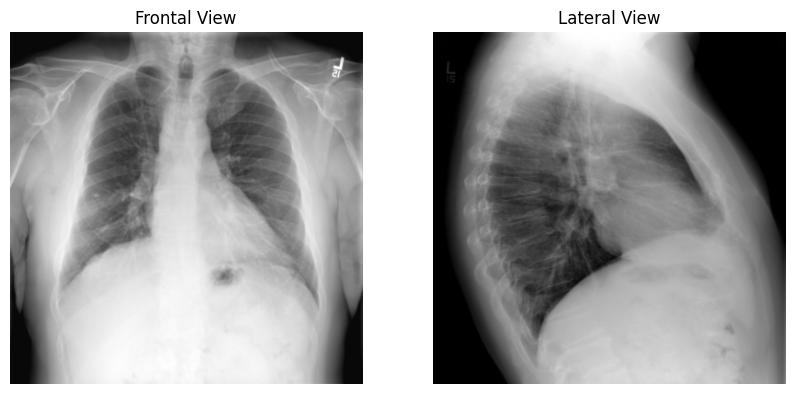

True Caption: PA and lateral views of the chest were obtained. The cardiomediastinal silhouette is normal in size and configuration. The lungs are well aerated. There is no pneumothorax, pleural effusion, or focal air space consolidation. Old right rib fractures.
Pred Caption: 
--------------------------------------------------


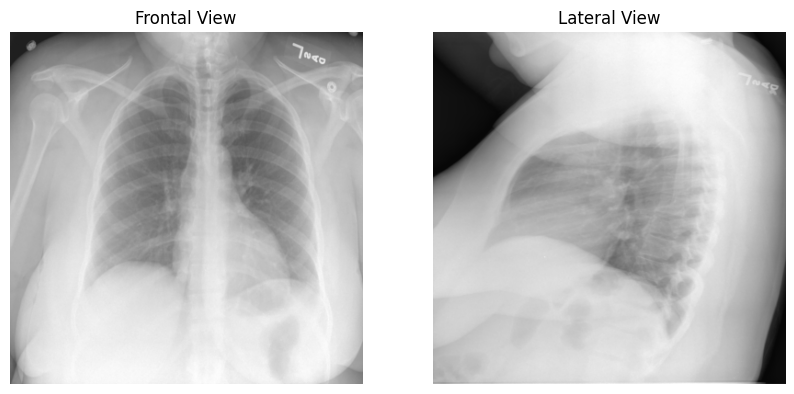

True Caption: Normal cardiomediastinal silhouette. There is no focal consolidation. There are no XXXX of a large pleural effusion. There is no pneumothorax. There is no acute bony abnormality seen.
Pred Caption:  cardiac contours. Normal heart size. No pneumothorax or pleural effusions. Very good lung circulation, good heart size.
--------------------------------------------------


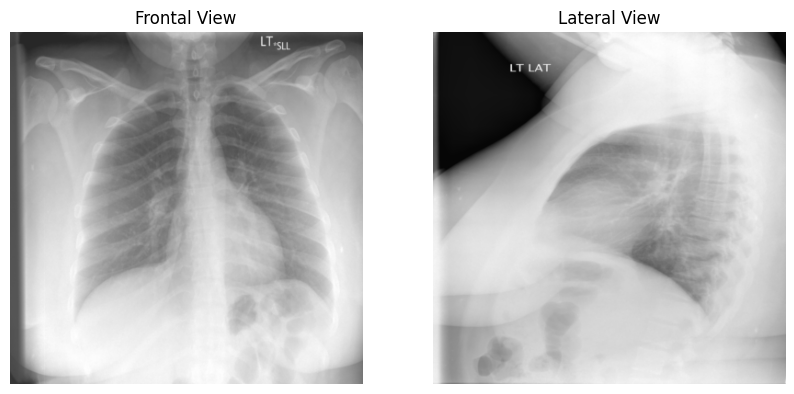

True Caption: Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality.
Pred Caption: iStockphoto.com/Luxurious-survey-satisfied.mp3
--------------------------------------------------


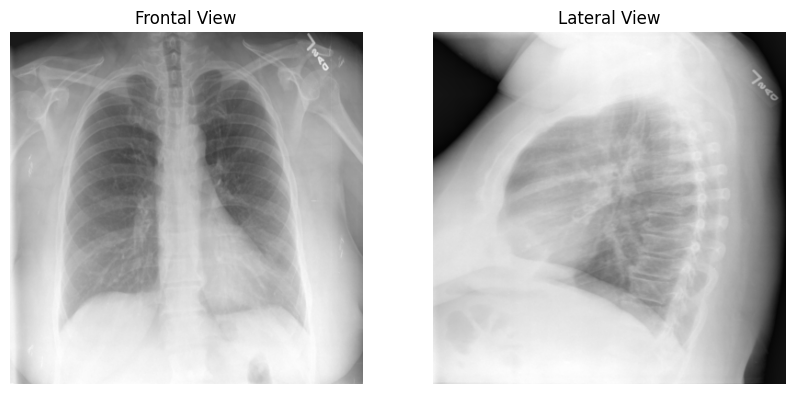

True Caption: There are no focal areas of consolidation. No suspicious pulmonary opacities. Heart size within normal limits. No pleural effusions. There is no evidence of pneumothorax. Degenerative changes of the thoracic spine.
Pred Caption:  heart size and pulmonary vascularity appear within normal limits. The lungs and bony structures provide an excellent base of operations for future studies. No pleural effusions or pneumothoraces is seen.
--------------------------------------------------


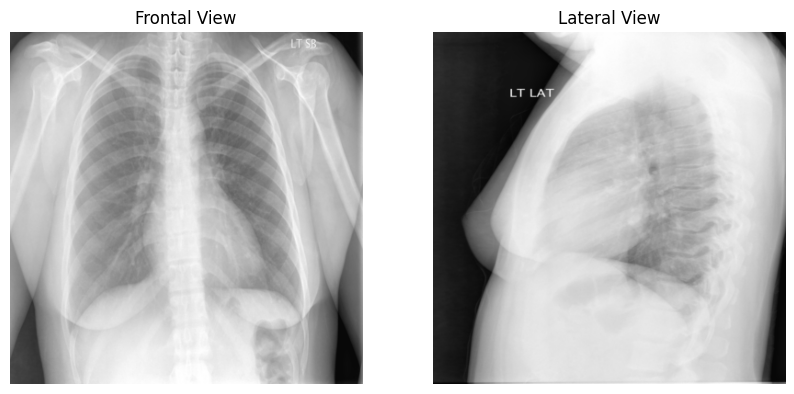

True Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
Pred Caption: 
--------------------------------------------------


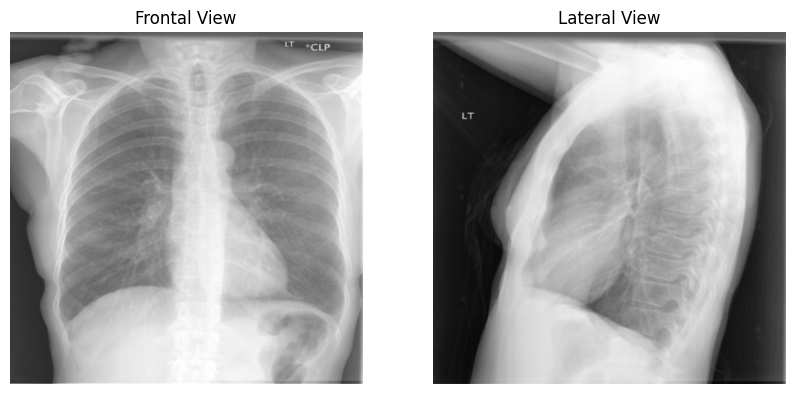

True Caption: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.
Pred Caption:  are unstable. No pleural effusions or pneumothoraces. Heart size and pulmonary vascularity are normal. There is no focal airspace opacities. No free air or sea air. No bony abnormalities. There are degenerative changes of the spine.
--------------------------------------------------


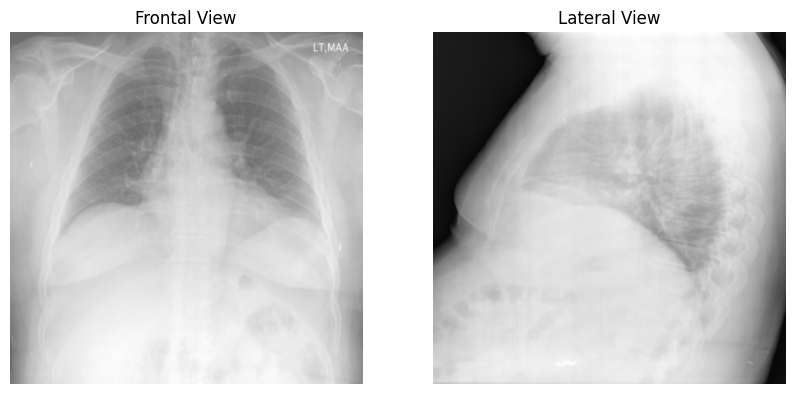

True Caption: Low lung volumes. Normal heart size. The trachea is midline. Lungs are clear. No pneumothorax. No pleural effusion.
Pred Caption: i, v, cord. No cord obstruction. No pulmonary edema. No pleural effusion.
--------------------------------------------------


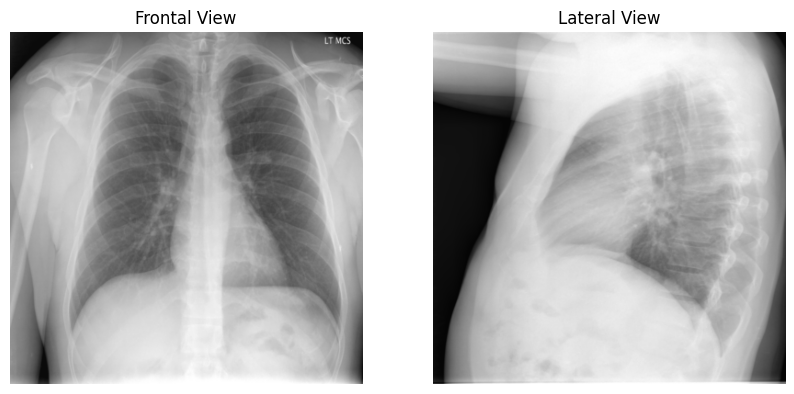

True Caption: The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.
Pred Caption: 
--------------------------------------------------


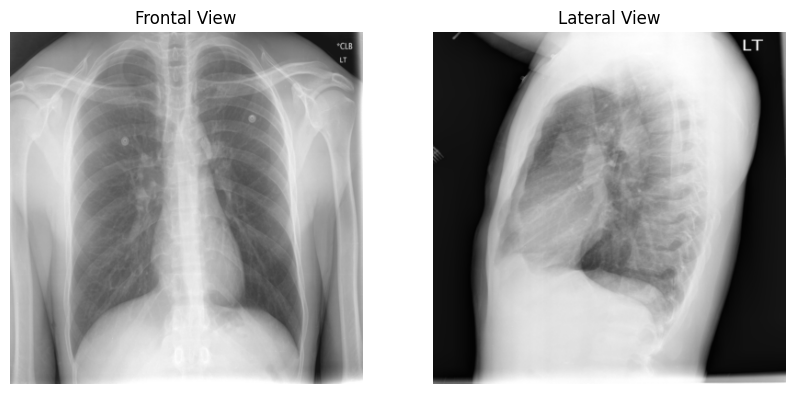

True Caption: Lungs are clear. There is no pneumothorax or pleural effusion. Calcified left suprahilar XXXX. The heart and mediastinum are within normal limits. Bony structures are intact.
Pred Caption: irreducibly low CABG activity in the left lower lobe. The pulmonary vasculature and vasculature appear normal. No pulmonary nodules or masses in the lungs indicate a pneumonia. No pleural effusion indicated. The lungs are clear of airborne organisms or pathogens.
--------------------------------------------------


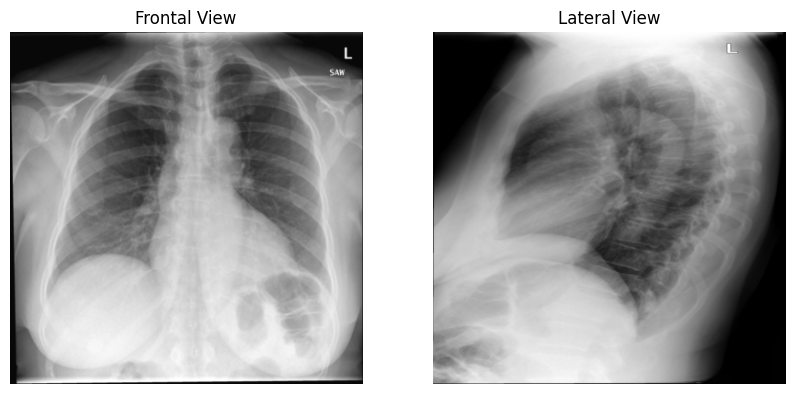

True Caption: Heart size, aortic and mediastinal contours are within normal limits. The lungs are clear. No visible pneumothorax or large pleural effusion. 6 mm nodular opacity overlies the left anterior 5th rib on the frontal view. No focal bony abnormality identified.
Pred Caption: 
--------------------------------------------------


In [23]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import warnings
import logging
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Disabilita tutti i warning
warnings.filterwarnings('ignore')
# Ignora i warning specifici di 'transformers'
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
# Imposta il livello di logging su ERROR per ignorare i messaggi INFO e WARNING
logging.getLogger("transformers").setLevel(logging.ERROR)


def calculate_bleu(pred_ids, ref_ids, tokenizer):
    """
    Calcola i punteggi BLEU-1, BLEU-2, BLEU-3, BLEU-4.
    """
    pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)
    ref_tokens = tokenizer.convert_ids_to_tokens(ref_ids)

    # Evita problemi con sequenze vuote
    if not pred_tokens or not ref_tokens:
        return (0.0, 0.0, 0.0, 0.0)

    smoothing = SmoothingFunction().method1
    bleu1 = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    return bleu1, bleu2, bleu3, bleu4

def calculate_rouge_l(predicted_text, reference_text):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(reference_text, predicted_text)
    return score['rougeL'].fmeasure

def test(model, test_loader, tokenizer):
    model.eval()
    total_bleu1 = total_bleu2 = total_bleu3 = total_bleu4 = 0
    total_rouge_l = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            # Genera i report solo dal latent space
            gen_ids = model.generate_report(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                device=device
            )

            # Calcolo dei punteggi BLEU e ROUGE-L sui testi generati
            for pred_ids, ref_ids in zip(gen_ids, batch['input_ids_caption']):
                bleu1, bleu2, bleu3, bleu4 = calculate_bleu(pred_ids.tolist(), ref_ids.tolist(), tokenizer)
                total_bleu1 += bleu1
                total_bleu2 += bleu2
                total_bleu3 += bleu3
                total_bleu4 += bleu4

                predicted_text = tokenizer.decode(pred_ids.tolist(), skip_special_tokens=True)
                reference_text = tokenizer.decode(ref_ids.tolist(), skip_special_tokens=True)
                rouge_l_score = calculate_rouge_l(predicted_text, reference_text)
                total_rouge_l += rouge_l_score

    dataset_size = len(test_loader.dataset)
    metrics = {
        'bleu1': total_bleu1 / dataset_size,
        'bleu2': total_bleu2 / dataset_size,
        'bleu3': total_bleu3 / dataset_size,
        'bleu4': total_bleu4 / dataset_size,
        'rouge_l': total_rouge_l / dataset_size
    }

    print("\nTest Results:")
    print(f"BLEU-1 Score: {metrics['bleu1']:.4f}")
    print(f"BLEU-2 Score: {metrics['bleu2']:.4f}")
    print(f"BLEU-3 Score: {metrics['bleu3']:.4f}")
    print(f"BLEU-4 Score: {metrics['bleu4']:.4f}")
    print(f"ROUGE-L Score: {metrics['rouge_l']:.4f}")

    return metrics

def visualize_predictions(model, test_loader, tokenizer, num_images=5):
    model.eval()
    visualizations_shown = 0

    with torch.no_grad():
        for batch in test_loader:
            # Genera i report solo dal latent space
            gen_ids = model.generate_report(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                device=device
            )

            for i in range(len(gen_ids)):
                if visualizations_shown >= num_images:
                    return

                # Decode captions and problems
                pred_caption = tokenizer.decode(gen_ids[i].tolist(), skip_special_tokens=True)
                true_caption = tokenizer.decode(batch['input_ids_caption'][i].tolist(), skip_special_tokens=True)
                
                # Plot images
                plt.figure(figsize=(10, 5))

                # Plot frontal image
                plt.subplot(1, 2, 1)
                plt.imshow(batch['front_pixel_values'][i].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.title('Frontal View')

                # Plot lateral image
                plt.subplot(1, 2, 2)
                plt.imshow(batch['lateral_pixel_values'][i].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.title('Lateral View')

                plt.show()

                # Print predictions and true values
                print(f"True Caption: {true_caption}")
                print(f"Pred Caption: {pred_caption}")
                print('-' * 50)

                visualizations_shown += 1


# Assicurati che il modello sia sulla GPU prima di iniziare
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Run tests and visualize predictions
metrics = test(model, test_loader, tokenizer)
visualize_predictions(model, test_loader, tokenizer, num_images=10)

In [24]:
# THIS FUNCTION EVALUATE THE MODEL PREDICTION FOR ALL THE RISK CATEGORIES
def evaluate_predictions_full(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    correct_predictions = 0
    total_predictions = 0

    class_correct = torch.zeros(num_class_pred, dtype=torch.int32)
    class_total = torch.zeros(num_class_pred, dtype=torch.int32)

    with torch.no_grad():
        for batch in val_loader:
            front_img = batch['front_pixel_values']
            lateral_img = batch['lateral_pixel_values']
            labels = torch.argmax(batch['risk_category'], dim=1)

            outputs = model(
                front_img, 
                lateral_img, 
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption'],
            )
            logits = outputs["classification_logits"]
            predicted_labels = torch.argmax(logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

            # Accuratezze di classe
            for class_label in range(num_class_pred):
                class_correct[class_label] += ((predicted_labels == class_label) &
                                               (labels == class_label)).sum().item()
                class_total[class_label] += (labels == class_label).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy su tutto il set di validazione: {accuracy:.2f}%")

    print("\nAccuratezze relative per classe:")
    for class_label in range(num_class_pred):
        if class_total[class_label] > 0:
            class_accuracy = 100.0 * class_correct[class_label] / class_total[class_label]
            print(f"Classe {class_label}: {class_accuracy:.2f}% "
                  f"({class_correct[class_label]}/{class_total[class_label]})")
        else:
            print(f"Classe {class_label}: Nessun campione presente.")

# Chiamata alla funzione di valutazione
evaluate_predictions_full(model, test_loader)

Accuracy su tutto il set di validazione: 87.55%

Accuratezze relative per classe:
Classe 0: 99.16% (473/477)
Classe 1: 75.38% (343/455)


<Figure size 1000x800 with 0 Axes>

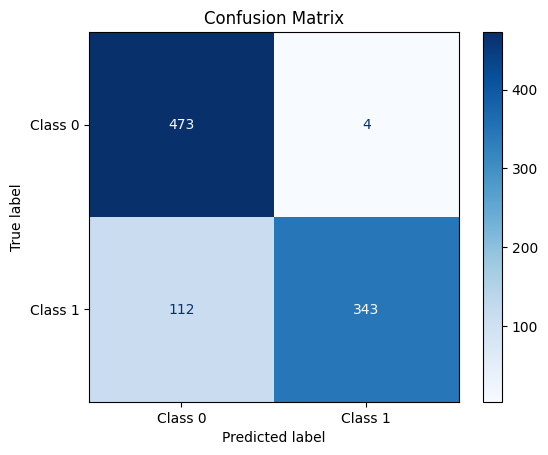

In [25]:
# IMPORT NECESSARY LIBRARIES
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# FUNCTION TO EVALUATE PREDICTIONS AND PRINT CONFUSION MATRIX
def evaluate_predictions_with_confusion_matrix(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in val_loader:
            front_img = batch['front_pixel_values']
            lateral_img = batch['lateral_pixel_values']
            labels = torch.argmax(batch['risk_category'], dim=1).cpu().numpy()

            outputs = model(
                front_img, 
                lateral_img, 
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption'],
            )
            logits = outputs["classification_logits"]
            predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

            # Collect all predictions and labels
            all_labels.extend(labels)
            all_predictions.extend(predicted_labels)

    # Calculate and display confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f"Class {i}" for i in range(num_class_pred)])
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# CALL THE FUNCTION
evaluate_predictions_with_confusion_matrix(model, test_loader)